# Drug-likeness of recombined ligands vs. PKIDB ligands

In order to assess the drug-likeness of our > 15M recombined ligands, we (i) calculate the drug-likeness of our recombined ligands and (ii) compare it to the drug-likeness of ligands from the PKIDB, which are approved and investigorial kinase inhibitors and therefore give an idea on how an ideal kinase inhibitor's drug-likeness looks like.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

RDKit WARNING: [10:53:08] Enabling RDKit 2019.09.3 jupyter extensions


## Get PKIDB ligands

In [2]:
url = 'https://raw.githubusercontent.com/dominiquesydow/pkidb_klifs/master/results/pkidb_20200218.csv'
pkidb_ligands = pd.read_csv(url, index_col=0)

## Get recombined ligands

In [3]:
recomb_ligands_path = Path('/home/paula/Masterarbeit/CombinatorialLibrary_manuscript/combinatorial_library.pickle')

## Get drug-likeness

### Definitions

In [4]:
def drug_likeness_from_mol(mol):
    """
    Get drug-likeness criteria for a molecule, i.e. molecular weight, logP, number of hydrogen bond acceptors/donors and 
    accordance to Lipinski's rule of five. 
    (Takes about 1s for 2000 mols.)
    
    Parameters
    ----------
    mol : rdkit.Chem.rdchem.Mol
        Molecule.
        
    Returns
    -------
    pd.Series
        Drug-likeness criteria for input molecule.
    """

    mw = 1 if Descriptors.ExactMolWt(mol) <= 500 else 0
    logp = 1 if Descriptors.MolLogP(mol) <= 5 else 0
    hbd = 1 if Lipinski.NumHDonors(mol) <= 5 else 0
    hba = 1 if Lipinski.NumHAcceptors(mol) <= 10 else 0
    lipinski = 1 if mw + logp + hbd + hba >= 3 else 0

    return pd.Series([mw, logp, hbd, hba, lipinski], index='mw logp hbd hba lipinski'.split())

In [5]:
def drug_likeness_from_smiles(smiles):
    """
    Get drug-likeness for a set of SMILES
    
    Parameters
    ----------
    smiles : pd.Series
        Set of SMILES.
        
    Returns
    -------
    pd.DataFrame
        Drug-likeness criteria (columns) for all input SMILES (rows).
    """
    
    drug_likeness = pd.DataFrame(
        smiles.apply(
            lambda x: drug_likeness_from_mol(Chem.MolFromSmiles(x))
        )
    )
    return drug_likeness

### Drug likeness for PKIDB ligands (approved and investigorial kinase inhibitors)

In [6]:
drug_likeness_pkidb = drug_likeness_from_smiles(pkidb_ligands.Canonical_Smiles)
bar_pkidb = round(drug_likeness_pkidb.apply(sum) / len(drug_likeness_pkidb) * 100, 1)
bar_pkidb

mw           70.2
logp         74.3
hbd         100.0
hba          98.6
lipinski     85.3
dtype: float64

### Drug likeness for recombined ligands

In [7]:
bar_recomb = pd.Series([24.6, 63.6, 95.5, 55.9, 39.5], index='mw logp hbd hba lipinski'.split())
bar_recomb

mw          24.6
logp        63.6
hbd         95.5
hba         55.9
lipinski    39.5
dtype: float64

## Plot drug likeness

In [8]:
bar_data = pd.DataFrame([bar_pkidb, bar_recomb])
bar_data.index = ['PKIDB ligands', 'Recombined ligands']
bar_data = bar_data.transpose()

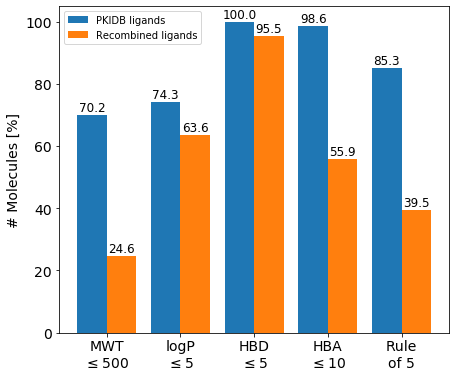

In [9]:
# Plot data
ax = bar_data.plot(
    kind='bar',
    width=0.8,
    rot=0,
    figsize=(7,6)
)

# Edit labels for y axis and x/y ticks
plt.ylabel('# Molecules [%]', fontsize=14)
plt.xticks(range(5), ['MWT\n'+r'$\leq 500$', 'logP\n'+r'$\leq 5$', 'HBD\n'+r'$\leq 5$', 'HBA\n'+r'$\leq 10$', 'Rule\nof 5'], fontsize=14)
plt.yticks(fontsize=14)

# Add percentages to bars
bars = ax.patches
bar_labels = bar_data.transpose().values.flatten()
for bar, label in zip(bars, bar_labels):
    
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        bar.get_height() + 0.2, 
        label, 
        ha='center', 
        va='bottom', 
        fontsize=12
    )